# Homework 3 (WIP)

Write a solver for the regularized $p$-Laplacian,
$$ -\nabla\cdot\big( \kappa(\nabla u) \nabla u \big) = 0 $$
where
$$ \kappa(\nabla u) = \big(\frac 1 2 \epsilon^2 + \frac 1 2 \nabla u \cdot \nabla u \big)^{\frac{p-2}{2}}, $$
$ \epsilon > 0$, and $1 < p < \infty$.  The case $p=2$ is the conventional Laplacian. This problem gets more strongly nonlinear when $p$ is far from 2 and when $\epsilon$ approaches zero. The $p \to 1$ limit is related to plasticity and has applications in non-Newtonion flows and structural mechanics.

1. Implement a "Picard" solver, which is like a Newton solver except that the Jacobian is replaced by the linear system
$$ J_{\text{Picard}}(u) \delta u \sim -\nabla\cdot\big( \kappa(\nabla u) \nabla \delta u \big) . $$
This is much easier to implement than the full Newton linearization.  How fast does this method converge for values of $p < 2$ and $p > 2$?

* Use the linearization above as a preconditioner to a Newton-Krylov method.  That is, use [`scipy.sparse.linalg.LinearOperator`](https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.sparse.linalg.LinearOperator.html) to apply the Jacobian to a vector
$$ \tilde J(u) v = \frac{F(u + h v) - F(u)}{h} . $$
Then for each linear solve, use [`scipy.sparse.linalg.gmres`](https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.sparse.linalg.gmres.html) and pass as a preconditioner, a direct solve with the Picard linearization above. (You might find [`scipy.sparse.linalg.factorized`](https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.sparse.linalg.factorized.html#scipy.sparse.linalg.factorized) to be useful. Compare algebraic convergence to that of the Picard method.

* Can you directly implement a Newton linearization?  Either do it or explain what is involved.  How will its nonlinear convergence compare to that of the Newton-Krylov method?

In [54]:
%precision 3
#%matplotlib notebook
%matplotlib inline

import numpy
from matplotlib import pyplot
import scipy.sparse as sp
import scipy.sparse.linalg
pyplot.style.use('ggplot')

def hgrid(h):
    m = int(1/h + 1)  # Number of elements in terms of nominal grid spacing h
    h = 1 / (m-1)     # Actual grid spacing
    c = numpy.linspace(0, 1, m)
    y, x = numpy.meshgrid(c, c)
    return x, y

def grid_spacing(h):
    m = int(1/h + 1)  # Number of elements in terms of nominal grid spacing h
    return 1 / (m-1)  # Actual grid spacing

## Picard Solver Implementation

The code below implements a Picard solver for the _p_-Laplacian problem,
$$ -\nabla\cdot\big( \kappa(\nabla u) \nabla u \big) = f(x,y)\\
\kappa(\nabla u) = \big(\frac 1 2 \epsilon^2 + \frac 1 2 \nabla u \cdot \nabla u \big)^{\frac{p-2}{2}} $$

In [55]:
def p_laplacian_picard(h, x, y, u, forcing, g0, eps, p, dirichlet=((),())):
    """
    Approximates a solution to the P-Laplacian:
      -1 * div(kappa(grad(u)) * grad(u)) = 0
      kappa(grad(u)) = 
          ((0.5 * eps^2) + (0.5 * grad(u) dot grad(u))) ^ ((p-2)/2)
    
    Parameters:
      h: grid size (the value passed to hgrid)
      x: x-coordinates of the grid
      y: y-coordinates of the grid
      u: the current approximation for u 
      forcing: f(x,y) forcing function for the problem
      g0: function for Dirichlet boundary -- u(x,y) = g0(x, y)
      eps: value of epsilon in the P-Laplacian
      p: value of p in the P-Laplacian
      dirichlet: where to impose Dirichlet boundary conditions (x, y)
          - first element can be 0 for left boundary
          - second element can be -1 for right boundary 
        E.g., ((0, -1), (0, -1)) for all Dirichlet conditions
        (0 and -1 are used as array indices: first and last elements)
    """
    
    # Stencil to evaluate gradient at four staggered points
    grad = numpy.array([[-1, 0, 1, 0, 0],
                        [0, -1, 1, 0, 0],
                        [0, 0, -1, 1, 0],
                        [0, 0, -1, 0, 1]]) / h
    # Stencil to compute divergence at cell centers from fluxes at four 
    # staggered points
    div = numpy.array([-1, -1, 1, 1]) / h

    m = x.shape[0]
    u0 = g0(x, y).flatten()
    
    F = -forcing(x, y).flatten()
    
    # COO representation of the A matrix (the WIP J)
    ai = []
    aj = []
    av = []

    # Convenience function for accessing grid elements
    def idx(i, j):
        i = (m-1) - abs(m-1 - abs(i))
        j = (m-1) - abs(m-1 - abs(j))
        return i*m + j

    # Create the mask and set the indices corresponding to Dirichlet BCs to 0
    mask = numpy.ones_like(x, dtype=bool)
    mask[dirichlet[0],:] = False
    mask[:,dirichlet[1]] = False
    mask = mask.flatten()

    u = u.flatten()
    F[mask == False] = u[mask == False] - u0[mask == False]
    u[mask == False] = u0[mask == False]

    for i in range(m):
        for j in range(m):
            row = idx(i, j)
            stencili = numpy.array([idx(*pair) for pair in [
                (i-1, j), (i, j-1), (i, j), (i, j+1), (i+1, j)]])
            ustencil = u[stencili]
            ugrad = grad @ ustencil
            
            kappa = numpy.zeros_like(ugrad) + (
                0.5 * eps ** 2 + 0.5 * numpy.inner(ugrad, ugrad)) ** ((p-2) / 2)
            
            if mask[row] == 0: # If this (i, j) is on a Dirichlet boundary
                ai.append(row)
                aj.append(row)
                av.append(1)
            else:
                F[row] -= div @ (kappa[:,None] * grad @ ustencil)
                Jstencil = -div @ (kappa[:,None] * grad)
                smask = mask[stencili]
                ai += [row]*sum(smask)
                aj += stencili[smask].tolist()
                av += Jstencil[smask].tolist()

    J = sp.csr_matrix((av, (ai, aj)), shape=(m*m,m*m))
    return F, J
    

def solve_p_laplacian_picard(h, g0, forcing, eps, p, dirichlet, atol=1e-8, verbose=False):
    x, y = hgrid(h)
    u = 0*x
    
    # Each time around the loop, you'll start with a new initial guess u
    for i in range(50):
        # Compute residual and Jacobian at u
        F, J = p_laplacian_picard(h, x, y, u, forcing,
                               g0, # g0, Dirichlet BC function
                               eps, 
                               p, 
                               dirichlet=((0,-1),(0,-1))) # all Dirichlet BCs
        
        # Break if the residual norm is lower than the tolerance
        anorm = numpy.linalg.norm(F, numpy.inf)
        if verbose:
            print('{:2d}: anorm {:8e}'.format(i,anorm))
        if anorm < atol:
            break
            
        # Solve and take a step
        deltau = sp.linalg.spsolve(J, -F)
        u += deltau.reshape(x.shape)

    return x, y, u, i

### Testing with a Manufactured Solution

To verify the results of the solver, we'll use a manufactured solution. Specifically, it'll be the one from lecture:
$$ u(x, y) = x e^{-2x} \tanh(1.2y+0.1) $$
To evaluate the terms needed in the problem, we'll use SymPy.

For the moment, here's one test to look at.

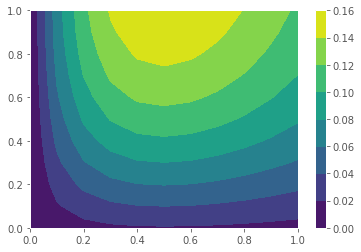

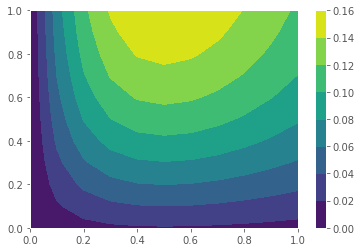

In [56]:
class mms_p_laplacian:
    def __init__(self, eps = 0, p = 2):
        import sympy
        from sympy.vector import gradient
        x, y = sympy.symbols('x y')

        uexpr = x * sympy.exp(-2*x) * sympy.tanh(1.2*y+.1)
        self.u = sympy.lambdify((x,y), uexpr)
        def grad_u(xx, yy):
            ux = sympy.lambdify((x,y), sympy.diff(u, x))
            uy = sympy.lambdify((x,y), sympy.diff(u, y))
            return ux(xx, yy), uy(xx, yy)
        
        graduexpr = gradient(uexpr)
        
        kexpr = ((0.5 * eps **2) + (0.5 * graduexpr.dot(graduexpr))) ** ((p-2)/2)
        self.kappa = sympy.lambdify((x,y), kexpr)
        def grad_kappa(xx, yy):
            kx = sympy.diff(kappa, x)
            ky = sympy.diff(kappa, y)
            return kx(xx, yy), ky(xx, yy)
        
        self.div_kappa_grad_u = sympy.lambdify((x,y),
                                              -(  sympy.diff(kexpr * sympy.diff(uexpr, x), x)
                                                + sympy.diff(kexpr * sympy.diff(uexpr, y), y)))    

eps = 1
p = 1.5

mms = mms_p_laplacian(eps, p)
x, y, u, i = solve_p_laplacian_picard(.1, 
    mms.u, # g0
    mms.div_kappa_grad_u, # forcing
    eps = eps,
    p = p,
    dirichlet=((0,-1),(0,-1)))

pyplot.figure()
pyplot.contourf(x, y, u)
pyplot.colorbar();

pyplot.figure()
pyplot.contourf(x, y, mms.u(x,y))
pyplot.colorbar();

That looks good. Let's try a convergence study with the same manufactured solution.

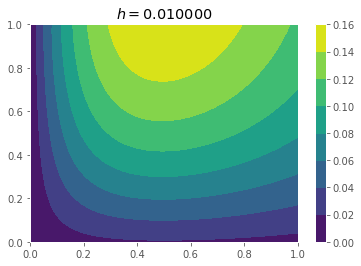

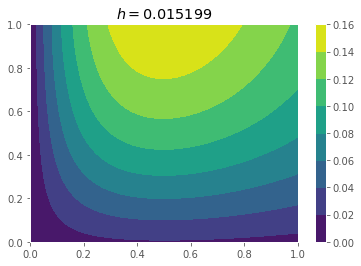

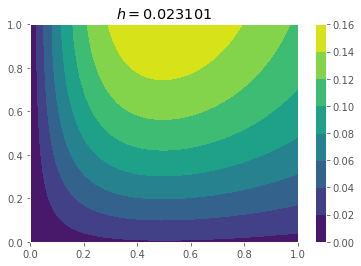

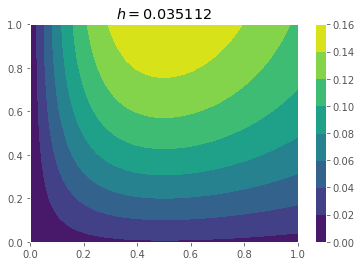

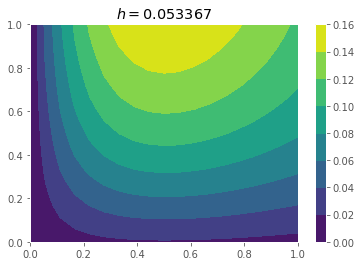

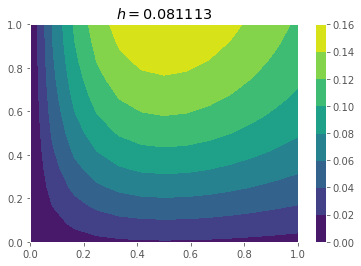

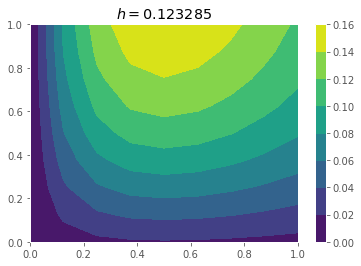

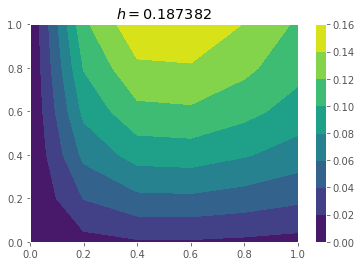

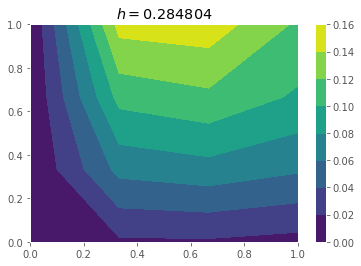

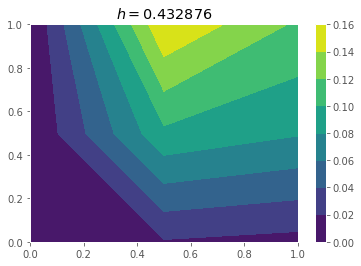

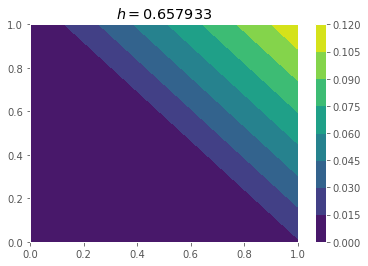

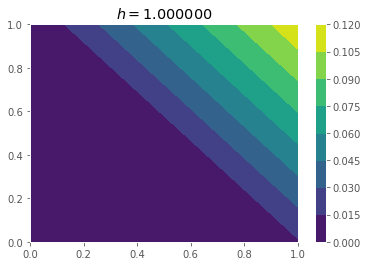

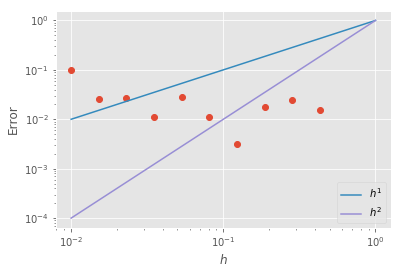

In [57]:
def mms_error(h, eps, p):
    """
    Computes the error for the Picard solver, applied to the p-Laplacian
    problem with the given epsilon and p values.
    
    Parameters:
      h: nominal grid size for the solver
      eps: value of epsilon in the P-Laplacian
      p: value of p in the P-Laplacian
      
    Returns:
      the infinity norm of the difference between the actual and 
      approximated u values on the grid
    """
    x, y = hgrid(h)
    u = 0*x

    mms = mms_p_laplacian(eps, p)
    
    # Run a single iteration
#     F, J = p_laplacian_picard(h, x, y, u, 
#                            mms.div_kappa_grad_u,
#                            mms.u, # g0, Dirichlet BC function
#                            eps, 
#                            p, 
#                            dirichlet=((0,-1),(0,-1))) # all Dirichlet BCs

#     actual = mms.u(x, y)
#     approx = sp.linalg.spsolve(J, -F).reshape(x.shape)
    
#     return numpy.linalg.norm(
#             approx - actual, 
#             numpy.inf)
    
    # Run method until it converges or is cut off
    x, y, approx, i = solve_p_laplacian_picard(h, 
        mms.u, # g0
        mms.div_kappa_grad_u, # forcing
        eps = eps,
        p = p,
        dirichlet=((0,-1),(0,-1)))
    
    pyplot.figure()
    pyplot.contourf(x, y, approx)
    pyplot.title("$h={{{:f}}}$".format(h))
    pyplot.colorbar();

    actual = mms.u(x, y)
    return numpy.linalg.norm(approx - actual)

eps = 1
p = 1.5
hs = numpy.logspace(-2, 0, 12)
errors = [mms_error(h, eps, p) for h in hs]

# Start a new figure and plot the error against comparison lines
pyplot.figure()
pyplot.loglog(hs, errors, 'o')
for i in range(1, 3):
    pyplot.loglog(hs, hs ** i, label="$h^{{{:d}}}$".format(i))
pyplot.xlabel('$h$')
pyplot.ylabel('Error')
pyplot.legend(loc='lower right')


And something's wrong.

### Convergence with Different $p$ Values

Here, we'll take a look at how the Picard solver converges for two cases of the $p$-Laplacian problem, $p=0.5$ (an instance of $p < 2$) and $p=3$ (an instance of $p > 2$). We'll use $\epsilon=0.1$, $f(x,y) = 1$ as the forcing function, and Dirichlet boundary conditions on all sides with the function $g_0(x,y) = 0$.

**p = 1.000, epsilon = 0.100
 0: anorm 1.000000e+00
 1: anorm 2.990593e-02
 2: anorm 7.770315e-04
 3: anorm 1.520504e-05
 4: anorm 2.561943e-07
 5: anorm 3.934888e-09
5 iteration(s)
**p = 3.000, epsilon = 0.100
 0: anorm 1.000000e+00
 1: anorm 1.182237e-01
 2: anorm 9.350163e-03
 3: anorm 5.799862e-04
 4: anorm 3.118485e-05
 5: anorm 1.522277e-06
 6: anorm 6.940634e-08
 7: anorm 3.012202e-09
7 iteration(s)


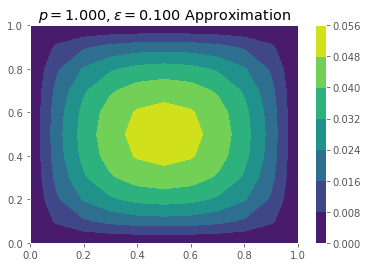

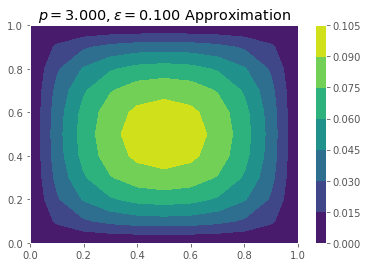

In [58]:
def demo_solver(eps = 0.1, p = 2, verbose = False, show_plot = True):
    print("**p = {:.3f}, epsilon = {:.3f}".format(float(p), float(eps)))
    
    x, y, u, i = solve_p_laplacian_picard(.1, 
        lambda x,y: numpy.zeros_like(x), # g0
        lambda x,y: numpy.ones_like(x),  # forcing
        eps = 1,
        p = p,
        dirichlet=((0,-1),(0,-1)),
        verbose=verbose)
    
    if show_plot:
        pyplot.figure()
        pyplot.contourf(x, y, u)
        pyplot.title("$p={{{:.3f}}}, \epsilon={{{:.3f}}}$ Approximation".format(float(p), float(eps)))
        pyplot.colorbar()
        
    print("{:d} iteration(s)".format(i))

demo_solver(p=1, verbose=True)
demo_solver(p=3, verbose=True)

It takes longer for the solution to converge in the $p=3$ case than in the $p=1.5$ case. 

This appears to occur in general; lower $p$ values, closer to one, require fewer iterations to converge, and more iterations are required as $p$ grows. See below for a some more test cases.

In [59]:
demo_solver(p=1.01, show_plot=False)
demo_solver(p=1.001, show_plot=False)
demo_solver(p=5, show_plot=False)
demo_solver(p=7, show_plot=False)
demo_solver(p=10, show_plot=False)
demo_solver(p=11, show_plot=False)

**p = 1.010, epsilon = 0.100
5 iteration(s)
**p = 1.001, epsilon = 0.100
5 iteration(s)
**p = 5.000, epsilon = 0.100
15 iteration(s)
**p = 7.000, epsilon = 0.100
37 iteration(s)
**p = 10.000, epsilon = 0.100
49 iteration(s)
**p = 11.000, epsilon = 0.100
49 iteration(s)


## Picard Solver as a Preconditioner

Next, we'll use $J_{Picard}$ as computed above as a preconditioner to a Newton-Krylov method. Additionally, we'll use the residual from the Picard solver to compute $\tilde{J}$ for this method as follows
$$ \tilde J(u) v = \frac{F(u + h v) - F(u)}{h} . $$

/usr/local/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:295: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


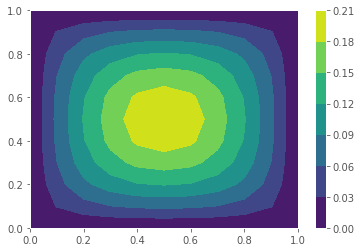

In [60]:
from scipy.sparse.linalg import LinearOperator
from scipy.sparse.linalg import gmres
from scipy.sparse.linalg import factorized 

def solve_p_laplacian_nk(h, g0, forcing, eps, p, dirichlet, rtol=1e-8, verbose=False):
    x, y = hgrid(h)
    u = 0*x
    
    Fu, J_picard = p_laplacian_picard(
        h, x, y, u, forcing, g0,
        eps, p, 
        dirichlet=((0,-1),(0,-1)))    
    norm0 = numpy.linalg.norm(Fu)    
        
    
    # Each time around the loop, you'll start with a new initial guess u
    for i in range(50):
        # From here, the residual will be part of the N-K Jacobian, and J_picard will
        # be used as a preconditioner to the N-K method.
        
        def jacobian(v):
            j_h = 10e-8
            Fuhv, _ = p_laplacian_picard(h, x, y, 
                u + j_h * v.reshape(u.shape),
                forcing, 
                g0,
                eps, 
                p, 
                dirichlet=((0,-1),(0,-1)))
        
            return (Fuhv - Fu) / j_h
        
        J_operator = LinearOperator(J_picard.shape, matvec=jacobian)
        preconditioner = LinearOperator(J_picard.shape, matvec=factorized(J_picard))
        deltau, _ = gmres(J_operator, -Fu, tol=0.001, M=preconditioner)
        u += deltau.reshape(x.shape)

        Fu, J_picard = p_laplacian_picard(
            h, x, y, u, forcing, g0,
            eps, p, 
            dirichlet=((0,-1),(0,-1)))    
        # Break if the residual norm is lower than the tolerance
        rnorm = numpy.linalg.norm(Fu)
        if verbose:
            print('{:2d}: norm {:8e}'.format(i,rnorm))
        if rnorm < rtol * norm0:
            break
            
    return x, y, u, i

x, y, u, i = solve_p_laplacian_nk(0.1, 
        lambda x,y: numpy.zeros_like(x), # g0
        lambda x,y: numpy.ones_like(x),  # forcing
        eps = 0.1,
        p = 3,
        dirichlet=((0,-1),(0,-1)))

pyplot.figure()
pyplot.contourf(x, y, u)
pyplot.colorbar()

Let's take a look at how the Newton-Krylov solver performs under grid refinement, using the same manufactured solution as before.

In [61]:
def convergence_study_nk(hs, eps, p):
    """
    Performs a convergence study for the Picard solver, applied to the p-Laplacian
    problem with the given epsilon and p values.
    
    Parameters:
      hs: list of h values to use for the study
      eps: value of epsilon in the P-Laplacian
      p: value of p in the P-Laplacian
      
    Returns:
      elements: array containing the number of grid elements in each iteration
      error: array containing the error for each iteration
    """
    error = []
    iterations = []
    rhs_fnc = lambda t: ddu(t) + a * du(t) + b * u(t)
    actual_hs = []
    
    for h in hs:
        # Calculate the approximate solution
        mms = mms_p_laplacian(eps, p)
        x, y, approx_points, i = solve_p_laplacian_nk(h, 
            mms.u,   # g0
            mms.div_kappa_grad_u, # forcing
            eps = eps,
            p = p,
            dirichlet=((0,-1),(0,-1)))
        
        # Record the error between the approximation and the actual solution
        actual_points = mms.u(x, y)
        error.append(numpy.linalg.norm(
            approx_points - actual_points, 
            numpy.inf))
        actual_hs.append(grid_spacing(h))
        iterations.append(i)
    
    elements = 1 / numpy.array(actual_hs)
    return elements, error, iterations

# hs_nk = numpy.logspace(-1.5, -.5, 8)
# elements_nk, error_nk, iterations_nk = convergence_study_nk(hs_nk, 4, 3)

# # Start a new figure and plot the error against comparison lines
# pyplot.figure()
# pyplot.loglog(hs_nk, error_nk, 'o')
# for i in range(1, 3):
#     pyplot.loglog(hs_nk, hs_nk ** i, label="$h^{{{:d}}}$".format(i))
# pyplot.xlabel('$h$')
# pyplot.ylabel('Error')
# pyplot.legend(loc='upper left')

...

**p = 1.500, epsilon = 0.100


/usr/local/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:295: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


49 iteration(s)
**p = 3.000, epsilon = 0.100
49 iteration(s)


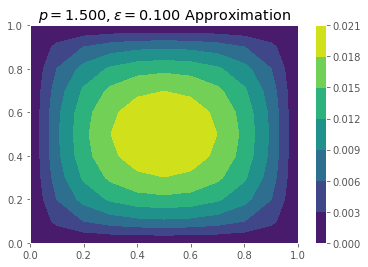

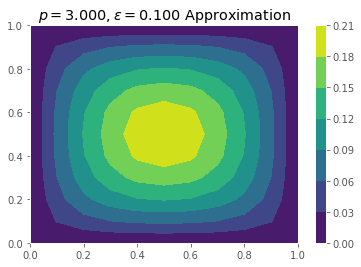

In [62]:
def demo_solver_nk(eps = 0.1, p = 2, verbose = False, show_plot = True):
    print("**p = {:.3f}, epsilon = {:.3f}".format(float(p), float(eps)))
    
    x, y, u, i = solve_p_laplacian_nk(0.1, 
        lambda x,y: numpy.zeros_like(x), # g0
        lambda x,y: numpy.ones_like(x),  # forcing
        eps = eps,
        p = p,
        dirichlet=((0,-1),(0,-1)),
        verbose=verbose)
    
    if show_plot:
        pyplot.figure()
        pyplot.contourf(x, y, u)
        pyplot.title("$p={{{:.3f}}}, \epsilon={{{:.3f}}}$ Approximation".format(float(p), float(eps)))
        pyplot.colorbar()
        
    print("{:d} iteration(s)".format(i))

demo_solver_nk(p=1.5, verbose=False)
demo_solver_nk(p=3, verbose=False)

Both instances hit the iteration count limit. So do $p=1$, $p=1.01$, and the same four $p$ values with $\epsilon=1$.

## Setting Up a Newton Linearization

If we were using a Newton linearization, we would need to fully calculate the Jacobian of $F$, which would notably require differentiating $\kappa(\nabla u)$.

Using a Newton method, we would expect quadratic convergence, in contrast to the linear convergence of the Newton-Krylov method.